# One Shot Learning
Deep learning models require large amounts of data. To attain appropriate hyperparameter tuning to attain a functional model, required data sets tend to be quite large. However that is not always convenient, humans are able to accurately classify objects with exposure to very small data sets. 

One shot Learning is the attempt to classify objects, with exposure to data sets much smaller than would typically be used in deep learning models.

In [1]:
import sys
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import random
random.seed(2) # Python
np.random.seed(1) #numpy
from tensorflow import set_random_seed
set_random_seed(3) # Tensorflow

In [3]:
#The path to the omniglot data
root_path = "/mnt/fbc0d8ef-f929-44c3-b2ee-3c536d9e0645/AI/Fellowship"
train_path = os.path.join(root_path,'images_background') 
validation_path = os.path.join(root_path,'images_evaluation')

def load_image(path, n = 0):
    X = []
    
    #Load every alphabet seperately and place that in one tensor
    for alphabet in os.listdir(path):
        print("Loading Alphabet: " + alphabet)
        alphabet_path = os.path.join(path, alphabet)
        
        #Each character in the alphabet is placed in a separate folder
        for letter in os.listdir(alphabet_path):
            category_images = []
            letter_path = os.path.join(alphabet_path, letter)
            
            if not os.path.isdir(letter_path):
                continue
            
            #Read evey image with in the directory
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imageio.imread(image_path)
                
                #Image preprocessing
                image = image/255
                image = 1 - image
                
                category_images.append(image)
                
            try:
                X.append(np.stack(category_images))
            except ValueError as e:
                print(e)
                print("error - category_images", category_images)
        
    X = np.stack(X)
    return X

In [4]:
print("Loading Training Set")
Xtrain = load_image(train_path)
print(Xtrain.shape)

print("Now loading evaluation set")
Xval = load_image(validation_path)
print(Xval.shape)

Loading Training Set
Loading Alphabet: Futurama
Loading Alphabet: Grantha
Loading Alphabet: Tifinagh
Loading Alphabet: Mkhedruli_(Georgian)
Loading Alphabet: Japanese_(hiragana)
Loading Alphabet: Gujarati
Loading Alphabet: Korean
Loading Alphabet: Asomtavruli_(Georgian)
Loading Alphabet: Early_Aramaic
Loading Alphabet: Anglo-Saxon_Futhorc
Loading Alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
Loading Alphabet: Balinese
Loading Alphabet: Sanskrit
Loading Alphabet: N_Ko
Loading Alphabet: Hebrew
Loading Alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
Loading Alphabet: Arcadian
Loading Alphabet: Tagalog
Loading Alphabet: Greek
Loading Alphabet: Japanese_(katakana)
Loading Alphabet: Burmese_(Myanmar)
Loading Alphabet: Malay_(Jawi_-_Arabic)
Loading Alphabet: Latin
Loading Alphabet: Alphabet_of_the_Magi
Loading Alphabet: Braille
Loading Alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
Loading Alphabet: Syriac_(Estrangelo)
Loading Alphabet: Bengali
Loading Alphabet: Armenian
Loading A

# Batch Creation

In [5]:
def get_batch(data, batch_size):
    n_classes, n_examples, w, h = data.shape
    
    pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]
    
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    categories = np.random.choice(n_classes, size = (batch_size,), replace = False)
    
    for i in range(batch_size):
        category = categories[i]
        
        idx1 = np.random.randint(0, n_examples)
        idx2 = np.random.randint(0, n_examples)
        
        if targets[i] == 0:
            category_2 = category
        else:
            category_2 = (category + np.random.randint(1, n_classes)) % n_classes
            
        pairs[0][i,:,:,:] = data[category, idx1].reshape(w, h, 1)
        pairs[1][i,:,:,:] = data[category_2, idx2].reshape(w, h, 1)
        
    return pairs, targets
        

In [6]:
def validation_batch(dataset, N):
    
    val_class, val_example, w, h = dataset.shape
    
    categories = np.random.choice(val_class, size = (N,), replace = False)
    true_category = categories[0]
    
    indices = np.random.randint(0, val_example, size = (N,))
    
    ex1, ex2 = np.random.choice(val_example,replace=False,size=(2,))
    
    #Use the same image to create a list N times to act as a test image
    test_image = np.asarray([dataset[true_category, ex1,:,:]]*N).reshape(N, w, h, 1)
    
    support_set = dataset[categories, indices,:,:]
    
    #Create the targets and fill in true character
    targets = np.zeros((N,))
    targets[0] = 1                                #Set the first target to be the true character
    support_set[0,:,:] = dataset[true_category, ex2] #Fill in this character
    
    #Reshape data and return it
    support_set = support_set.reshape(N,w,h,1)
    pairs = [test_image, support_set]
    return pairs, targets

# Visualise Characters

2


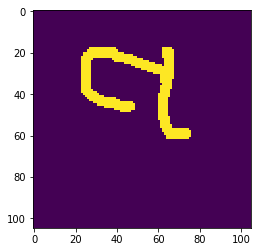

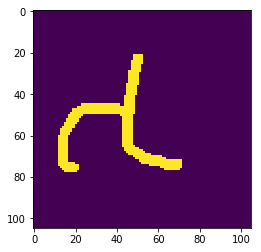

similarity/distance: 0.0


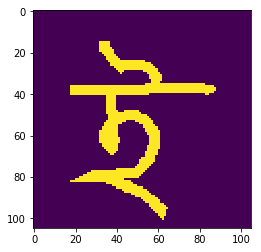

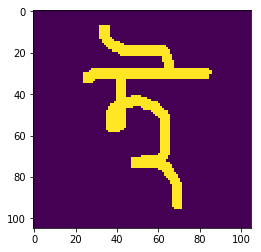

similarity/distance: 0.0


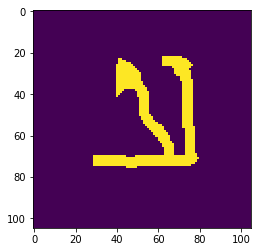

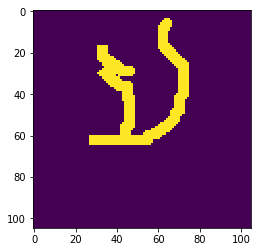

similarity/distance: 0.0


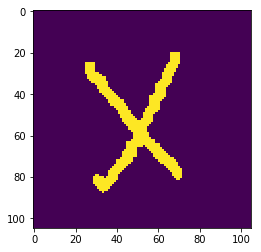

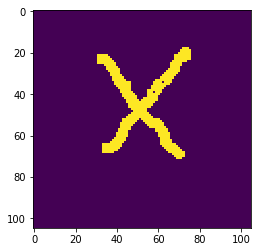

similarity/distance: 0.0


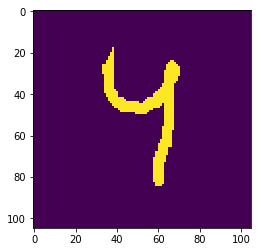

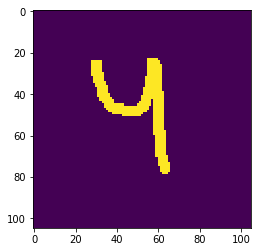

similarity/distance: 0.0


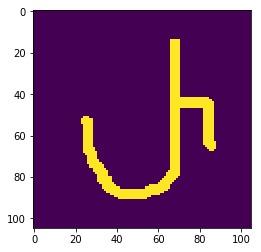

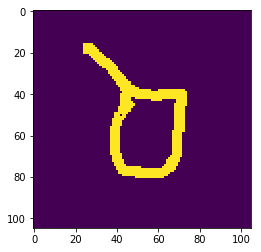

similarity/distance: 1.0


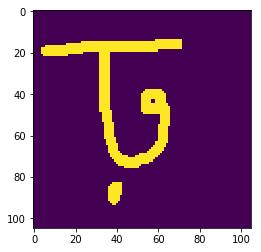

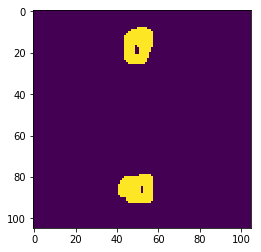

similarity/distance: 1.0


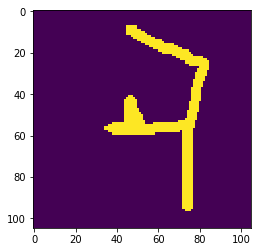

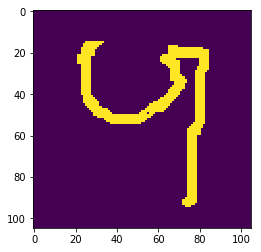

similarity/distance: 1.0


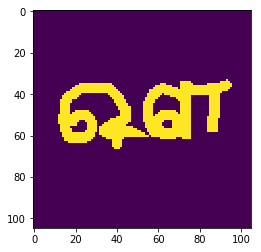

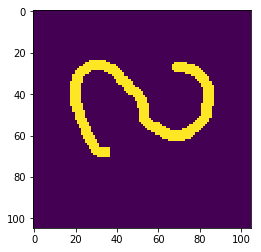

similarity/distance: 1.0


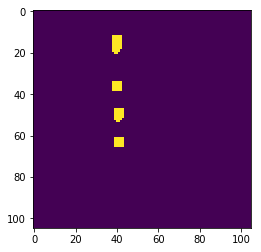

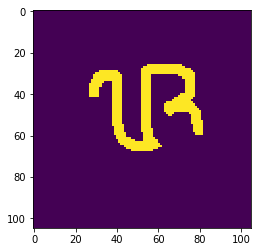

similarity/distance: 1.0


In [7]:
pairs, targets = get_batch(Xtrain, 10)
print(len(pairs))
for i in range(len(pairs[0])):
    image = np.reshape(pairs[0][i],(105,105))
    plt.imshow(image)
    plt.show()
    image = np.reshape(pairs[1][i],(105,105))
    plt.imshow(image)
    plt.show()
    
    print("similarity/distance: " + str(targets[i]))

# Model Architecture

In [8]:
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [9]:
#Contrastive Loss
def euclid_dist(input_pair):
    x, y = input_pair
    distance = K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))
    return distance

def euclid_dist_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = -1 * y_true + 1
    return K.mean((1-y_true) * K.square(y_pred) + y_true *  K.square(K.maximum(margin - y_pred, 0.0)))

def acc(y_true, y_pred):
    ones = K.ones_like(y_pred)
    return K.mean(K.equal(y_true, ones - K.clip(K.round(y_pred), 0, 1)), axis=-1)

def W_init(shape, name=None):
    values = np.random.normal(loc=0, scale=1e-2, size=shape)
    return K.variable(values,name=name)

In [10]:
im_width  = 105
im_height = 105
im_chan   = 1      # Number of channels: first is original and second cumsum(axis=0)

# Siamese Network
Siamese networks leverage two convolutional networks to solve the problem of One Shot Learning. The model will learn the embeddings of 2 different input images and attempt to calculate the Contrastive Loss function. Siamese networks are essentially two parallel CNN models. A single CNN architecture will have 9 layers comprised of max pooling and convolutions. The 9 layers carry out feature selection.

The model is optimized with an Adam optimizer and a randomly chosen value for the learning rate.

In [11]:
#Build U-Net model
#(im_height, im_width, im_chan) --> shape of input
input_img = Input((im_height, im_width, im_chan), name='img')

#Down Block 1
c1 = Conv2D(64,(10,10), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4) )(input_img)
p1 = MaxPooling2D() (c1)

#Down Block 2
c2 = Conv2D(128, (7, 7), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4)) (p1)
p2 = MaxPooling2D() (c2)

#Down Block 3
c3 = Conv2D(128, (4, 4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4)) (p2)
p3 = MaxPooling2D() (c3)

#Down Block 4
c4 = Conv2D(256, (4, 4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4)) (p3)
p4 = MaxPooling2D() (c4)

flat = Flatten()(p4)
output = Dense(4096, kernel_initializer=W_init, activation='sigmoid')(flat)


#Instantiate the Model
model = Model(input_img, output)

input1 = Input(shape = (105,105,1))
input2 = Input(shape = (105,105,1))

output1 = model(input1)
output2 = model(input2)


distance = Lambda(euclid_dist, output_shape=euclid_dist_shape)([output1, output2])

prediction = Dense(1, activation='sigmoid')(distance)
    
siamese = Model(inputs=[input1, input2], outputs=prediction)
    
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
siamese.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[acc])

siamese.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4096)         10636096    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

In [12]:
from tqdm import tqdm
batch_size = 64
TRAIN_BATCH = 20000
TEST_COUNT = 200
validate_batch = 500
best_val_acc = 0.0
N_WAY = 20
file_path = "weights550u6306t.hdf5"

intermediate_layer = Model(inputs=siamese.input, outputs=siamese.get_layer(index=3).output)
values = range(TRAIN_BATCH)
with tqdm(total=len(values), file=sys.stdout) as pbar:
    for i in range(TRAIN_BATCH):
        if(i % 500 == 0):
            pbar.write('processed: %d%s' % (1 + i, ' ' * 50))
        pbar.update(1)
        pairs, targets = get_batch(Xtrain, batch_size)
        #targets = [[t] for t in targets]
        loss = siamese.train_on_batch(pairs, targets)
        
        #Validates at validation interval
        if i % validate_batch == 0:
            correct_tested = 0
            for i in range(TEST_COUNT):
                pairs, targets = validation_batch(Xval, N_WAY)
                pred = intermediate_layer.predict_on_batch(pairs)

                maxindex = np.argmin(pred)

                if maxindex == 0:
                    correct_tested += 1

            val_acc = correct_tested / TEST_COUNT
            if val_acc == 1.0:
                print("Gradient Explosion")
                break
                
            #Tracking Accuracy Values
            print(' Accuracy ' + str(val_acc))
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                model.save_weights(file_path)

print("Best accuracy is " + str(best_val_acc))

processed: 1                                                  
  0%|          | 0/20000 [00:00<?, ?it/s] Accuracy 0.425
processed: 501                                                  
  3%|▎         | 501/20000 [00:59<35:03,  9.27it/s] Accuracy 0.21
processed: 1001                                                  
  5%|▌         | 1001/20000 [01:57<34:23,  9.21it/s] Accuracy 0.36
processed: 1501                                                  
  8%|▊         | 1501/20000 [02:55<33:26,  9.22it/s] Accuracy 0.465
processed: 2001                                                  
 10%|█         | 2001/20000 [03:53<32:42,  9.17it/s] Accuracy 0.565
processed: 2501                                                  
 13%|█▎        | 2501/20000 [04:51<31:45,  9.18it/s] Accuracy 0.685
processed: 3001                                                  
 15%|█▌        | 3001/20000 [05:49<30:49,  9.19it/s] Accuracy 0.785
processed: 3501                                                  
 18%|█▊       